# Southern California Air Quality Bot

This is a notebook for downloading air quality data from [PurpleAir](https://purpleair.com)
and broadcasting it on social media. If the air quality is *bad*, it can also tag in
relevant elected officials.

In [1]:
import os
from typing import Optional

import contextily
import geopandas
import matplotlib.pyplot as plt
import numpy
import pandas
import requests
from matplotlib.colors import LinearSegmentedColormap

## Download the data

We first download the data from Purple Air.

In [2]:
API_KEY = os.environ.get("PURPLEAIR_API_KEY")
FIELDS = [
    "name",
    "location_type",
    "latitude",
    "longitude",
    "humidity",
    "pm2.5_cf_1",
    "pm2.5_cf_1_a",
    "pm2.5_cf_1_b",

]
response = requests.get(
    "https://api.purpleair.com/v1/sensors",
    headers={"X-API-Key": API_KEY},
    params={
        "fields": ",".join(FIELDS),
        "max_age": 10*60,
        "nwlng": -119.4,
        "nwlat": 34.9,
        "selng": -116.6,
        "selat": 33.2,
    }   
)
response.raise_for_status()
data = response.json()
df = pandas.DataFrame.from_records(data=data["data"], columns=data["fields"])

In [3]:
gdf = geopandas.GeoDataFrame(
    df,
    geometry=geopandas.points_from_xy(df["longitude"], df["latitude"], crs="EPSG:4326")
)
# Filter to outdoors and recently-seen sensors. Age seems to be in minutes
gdf = gdf[(gdf.location_type == 0)]

## Compute AQI from the data

[airnow.gov](airnow.gov) has an PM2.5-to-AQI [calculator](https://www.airnow.gov/aqi/aqi-calculator-concentration/)
which [exposes](https://www.airnow.gov/sites/default/files/custom-js/conc-aqi.js) some human-readable javascript utils.
These are ported to Python here:

In [4]:
def aqi_from_pm(pm: float) -> Optional[float]:
    # Check for invalid readings. PM > 500 is off the scale.
    if pandas.isna(pm) or pm < 0 or pm >= 500.5:
        return None; 

    if pm > 0 and pm < 12.1:
        return linear(50, 0, 12, 0, pm)
    elif pm >= 12.1 and pm < 35.5:
        return linear(100, 51, 35.4, 12.1, pm)
    elif pm >= 35.5 and pm < 55.5:
        return linear(150, 101, 55.4, 35.5, pm)
    elif pm >= 55.5 and  pm < 150.5:
        return linear(200, 151, 150.4, 55.5, pm)
    elif pm >= 150.5 and pm < 250.5:
        return linear(300, 201, 250.4, 150.5, pm)
    elif pm >= 250.5 and pm < 350.5:
        return linear(400, 301, 350.4, 250.5, pm)
    elif pm >= 350.5 and pm < 500.5:
        return linear(500, 401, 500.4, 350.5, pm)
    else:
        return None

def linear(aqi_high, aqi_low, conc_high, conc_low, conc):
    return numpy.rint(
        ((aqi_high - aqi_low) / (conc_high - conc_low)) * (conc - conc_low) + aqi_low
    )

We also apply the EPA correction to raw Purple Air sensor data described
[here](https://cfpub.epa.gov/si/si_public_record_Report.cfm?dirEntryId=350075&Lab=CEMM),
which was calibrated to wildfire data in 2020 and removes some apparent systematic over-estimates.

In [5]:
# Calculate the AQI values and drop nulls.
gdf = (
    gdf
    .assign(
        aqi=(0.52 * gdf["pm2.5_cf_1"] - 0.085 * gdf.humidity + 5.71).apply(aqi_from_pm)
    )
    .dropna(subset=["aqi"])
)

## Create plots!

Administrative districts, especially LA City Council districts, can have weird shapes
due to historical contingencies and gerrymandering. This proved to have some odd effects
when doing simple point-in-polygon tests for sensors, as sensors which have relevant
data to a region were being cut out due to a weird wiggle in a boundary.

Instead, I create a buffered convex hull for each district and use that for filtering
to relevant sensor data.

<AxesSubplot:>

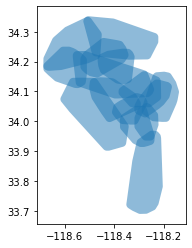

In [6]:
la_council_districts = geopandas.read_file("data/LA_City_Council_Districts_(Adopted_2021).geojson")

# Create an envelope with a 1 mile buffer
la_council_districts = (
    la_council_districts
    .to_crs(epsg=2229)
    .assign(envelope=lambda gdf: gdf.geometry.convex_hull.buffer(5280.))
    .set_geometry("envelope")
    .to_crs(epsg=4326)
    .set_geometry("geometry")
)

# A fun plot of the districts!
la_council_districts.set_geometry("envelope").plot(alpha=0.5,)

In [7]:
cmap = LinearSegmentedColormap.from_list(
    name="purpleair",
    colors=["green", "yellow", "red", "purple"]
)

In [8]:
twitter_accounts = {
    1: "@cmgilcedillo",
    2: "@PaulKrekorian",
    3: "@BobBlumenfield",
    4: "@cd4losangeles",
    5: "@PaulKoretzCD5",
    6: "@CD6Nury",
    7: "@MRodCD7",
    8: "@mhdcd8",
    9: "@CurrenDPriceJr",
    10: None,  # :(
    11: "@mikebonin",
    12: "@CD12LA",
    13: "@MitchOFarrell",
    14: "@kdeleon",  # mayoral campaign account vastly more used than @Kdeleoncd14"
    15: "@JoeBuscaino",
}   

In [9]:
def get_category(aqi: float) -> str:
    if aqi <=50:
        return "good"
    elif aqi > 50 and aqi <= 100:
        return "moderate"
    elif aqi > 100 and aqi <= 150:
        return "unhealthy for sensitive groups"
    elif aqi > 150 and aqi <= 200:
        return "unhealthy"
    elif aqi > 200 and aqi <= 300:
        return "very unhealthy"
    elif aqi > 300 and aqu <= 500:
        return "hazardous"
    else:
        return "out of range"

In [10]:
for i, district in la_council_districts.iterrows():
    district_gdf = gdf[gdf.geometry.within(district.envelope)]
    
    # Create text for a tweet
    aqi = int(numpy.rint(district_gdf.aqi.median()))
    category = get_category(aqi)
    message = f"""The residents of LA City Council District {district.District} are experiencing an air quality index of {aqi} ({category})."""
    if aqi > 100:
        handle = twitter_accounts.get(district.District)
        if not handle: # Woo, corruption!
            handle = "@MayorOfLA @CD6Nury"
        message += f"\n\n{handle} what are you doing to make sure that the people you represent have safe air to breathe?"
    display(message)

    # Set up the figure
    fig, ax = plt.subplots(figsize=(16,16))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    # Plot the CD outline
    la_council_districts[
        la_council_districts.District == district.District
    ].to_crs(epsg=3857).plot(ax=ax, color="blue", alpha=0.1)
    
    # Plot the data
    ax.axes.autoscale(False)
    district_gdf.to_crs(epsg=3857).plot(ax=ax, s=4000, alpha=0.7, column="aqi", cmap=cmap, vmin=0, vmax=200)
    for idx, sensor in district_gdf.to_crs(epsg=3857).iterrows():
        color = "black" if sensor["aqi"] < 120 else "white"
        ax.annotate(
            str(int(sensor["aqi"])),
            xy=(sensor.geometry.x, sensor.geometry.y),
            fontsize=16,
            ha="center",
            va="center",
            color=color,
            alpha=0.75,
            annotation_clip=True,
            clip_on=True,
        )
        
    # Add the basemap
    contextily.add_basemap(ax)
    
    # Output
    plt.close(fig)
    fig.savefig(f"cd{district.District}.png")
    # display(fig)

'The residents of LA City Council District 1 are experiencing an air quality index of 52 (moderate).'

'The residents of LA City Council District 2 are experiencing an air quality index of 31 (good).'

'The residents of LA City Council District 3 are experiencing an air quality index of 28 (good).'

'The residents of LA City Council District 4 are experiencing an air quality index of 33 (good).'

'The residents of LA City Council District 5 are experiencing an air quality index of 30 (good).'

'The residents of LA City Council District 6 are experiencing an air quality index of 30 (good).'

'The residents of LA City Council District 7 are experiencing an air quality index of 30 (good).'

'The residents of LA City Council District 8 are experiencing an air quality index of 54 (moderate).'

'The residents of LA City Council District 9 are experiencing an air quality index of 98 (moderate).'

'The residents of LA City Council District 10 are experiencing an air quality index of 35 (good).'

'The residents of LA City Council District 11 are experiencing an air quality index of 28 (good).'

'The residents of LA City Council District 12 are experiencing an air quality index of 24 (good).'

'The residents of LA City Council District 13 are experiencing an air quality index of 47 (good).'

'The residents of LA City Council District 14 are experiencing an air quality index of 48 (good).'

'The residents of LA City Council District 15 are experiencing an air quality index of 36 (good).'